In [1]:
import sys
sys.path.append('..')
# %%
import os
from matplotlib import pyplot as plt
import numpy as np
import h5py
from sklearn.model_selection import train_test_split

# utility module
from utilities import mkdir

import torch
from torch_tools import WaveformDataset, EarlyStopping, try_gpu, training_loop
from torch.utils.data import DataLoader
from autoencoder_1D_models_torch import Autoencoder_Conv1D_deep

os.chdir('..')

In [2]:
torch.cuda.is_available()
try_gpu()

device(type='cuda', index=0)

In [3]:
# make the output directory
model_dataset_dir = './Model_and_datasets_1D_STEAD'
mkdir(model_dataset_dir)

# %% Read the pre-processed datasets
model_datasets = './training_datasets/training_datasets_STEAD_waveform.hdf5'
with h5py.File(model_datasets, 'r') as f:
    X_train = f['X_train'][:]
    Y_train = f['Y_train'][:]

In [4]:
# 3. split to training (60%), validation (20%) and test (20%)
train_size = 0.6
test_size = 0.5
rand_seed1 = 13
rand_seed2 = 20
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, train_size=train_size, random_state=rand_seed1)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test, Y_test, test_size=test_size, random_state=rand_seed2)

# Convert to the dataset class for Pytorch (here simply load all the data,
# but for the sake of memory, can also use WaveformDataset_h5)
training_data = WaveformDataset(X_train, Y_train)
validate_data = WaveformDataset(X_validate, Y_validate)

In [5]:
model_name = "Autoencoder_conv1d_pytorch"
batch_size, epochs, lr = 128, 400, 1e-3
model = Autoencoder_Conv1D_deep(model_name).to(device=try_gpu())
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_iter = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validate_iter = DataLoader(validate_data, batch_size=batch_size, shuffle=True)

model, avg_train_losses, avg_valid_losses = training_loop(train_iter, validate_iter,
                                                          model, loss_fn, optimizer,
                                                          epochs=epochs, patience=20, device=try_gpu())
print("Training is done!")

[  1/400] train_loss: 0.40634 valid_loss: 0.20123
time per epoch: 9.456 s
Validation loss decreased (inf --> 0.201229).  Saving model ...
[  2/400] train_loss: 0.15013 valid_loss: 0.12805
time per epoch: 9.445 s
Validation loss decreased (0.201229 --> 0.128055).  Saving model ...
[  3/400] train_loss: 0.12090 valid_loss: 0.11906
time per epoch: 9.500 s
Validation loss decreased (0.128055 --> 0.119056).  Saving model ...
[  4/400] train_loss: 0.11594 valid_loss: 0.11874
time per epoch: 9.608 s
Validation loss decreased (0.119056 --> 0.118743).  Saving model ...
[  5/400] train_loss: 0.11298 valid_loss: 0.11381
time per epoch: 9.506 s
Validation loss decreased (0.118743 --> 0.113813).  Saving model ...
[  6/400] train_loss: 0.11093 valid_loss: 0.11054
time per epoch: 9.471 s
Validation loss decreased (0.113813 --> 0.110538).  Saving model ...
[  7/400] train_loss: 0.11002 valid_loss: 0.11339
time per epoch: 9.494 s
EarlyStopping counter: 1 out of 20
[  8/400] train_loss: 0.10803 valid_lo

In [6]:
# make the output directory to store the model information
model_dataset_dir = model_dataset_dir + '/' + model_name
mkdir(model_dataset_dir)

# %% Save the model
torch.save(model, model_dataset_dir + f'/{model_name}_Model.pth')

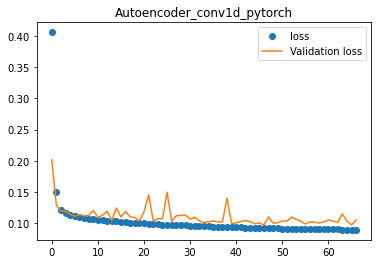

In [8]:
# %% Show loss evolution when training is done
loss = avg_train_losses
val_loss = avg_valid_losses
plt.figure()
plt.plot(loss, 'o', label='loss')
plt.plot(val_loss, '-', label='Validation loss')
plt.legend()
plt.title(model_name)
plt.show()
# store the model training history
with h5py.File(model_dataset_dir + f'/{model_name}_Training_history.hdf5', 'w') as f:
    f.create_dataset("loss", data=loss)
    f.create_dataset("val_loss", data=val_loss)

# add some model information
with h5py.File(model_dataset_dir + f'/{model_name}_Dataset_split.hdf5', 'w') as f:
    f.attrs['model_name'] = model_name
    f.attrs['train_size'] = train_size
    f.attrs['test_size'] = test_size
    f.attrs['rand_seed1'] = rand_seed1
    f.attrs['rand_seed2'] = rand_seed2